# Vision Transformers

List of main relevant papers:
* [Vaswani et al. (2017)](https://arxiv.org/pdf/1706.03762.pdf). Attention is all you need.
* [Dosovitskiy et al. (2021)](https://arxiv.org/abs/2010.11929). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale.

List of main relevant blogs:
* [Briggs and Carnevali (2023)](https://www.pinecone.io/learn/image-search/). Embedding methods for image search.
* [HuggingFace documentation on Vision Transformers](https://huggingface.co/docs/transformers/model_doc/vit)

List of main relevant Youtube videos:
* [Kilcher (2021)](https://www.youtube.com/watch?v=TrdevFK_am4). ViT paper explained.

-----

**Note:** This notebook is an extended version of [Briggs and Carnevali (2023). Chapter 5.](https://www.pinecone.io/learn/image-search/)

-----

# 1 - Introduction

Vision and language are the two big domains in machine learning. Two distinct disciplines with their own problems, best practices, and model architectures. At least, that *was* the case.

The **Vision Transformer (ViT)** [[Dosovitskiy et al. (2021)](https://arxiv.org/abs/2010.11929)] marks the first step towards the merger of these two fields into a single unified discipline. For the first time in the history of ML, a single model architecture has come to dominate both language and vision.

## 1.1 - Brief review of Transformers

Transformers were introduced by [Vaswani et al. (2017)](https://arxiv.org/pdf/1706.03762.pdf), where the primary function powering these models is the attention mechanism.

In NLP, the attention mechanism allows the model to selectively focus on different parts of the input sequence when generating an output. Attention mechanisms capture the relationships between different words or tokens in a sequence by assigning weights or importance scores to each input element.

Self-attention is a specific type of attention mechanism used in transformers. It computes the importance of each word in a sequence by measuring its relevance to all other words within the same sequence. This enables the model to capture long-range dependencies and contextual information effectively.

Before applying attention, the initial positions of our tokens are determined solely based on a general understanding of the word or sub-word token.

As we progress through multiple encoder blocks, which include the attention mechanism, the positions of these embeddings are updated to better reflect the token's meaning within its specific context. This context encompasses all the other words present in the given sentence.

Let's consider the following three phrases:

* A plane **banks**.
* The grassy **bank**.
* The **Bank** of England.

Initially, the embedding for the token "bank" is the same in all three phrases. However, as the token passes through multiple attention encoder blocks, it is gradually shifted towards its context-dependent meaning. These blocks might push the token "bank" closer to other tokens like [plane, airport, flight], [nature, fields, outdoors], or [finance, England, money], based on the attention and contextual information learned during the encoding process.

<table>
    <tr>
        <td><img src="./images_1/attention_1.png" width="600"/></td>
    </tr>
</table>

At the end of this process, we get information-rich embeddings. These embeddings are the ultimate output of the *core* of a Transformer. Another set of layers is then used to transform these rich embeddings into useful predictions. These final few layers are called the “head” and a different head is used for each task, such as for classification, named-entity-recognition, question-answering, etc.

## 1.2 - From text to images

In NLP, the input to transformers is typically a sequence of tokens, such as words or subwords. On the other hand, in computer vision tasks, **the input to ViT is an image divided into a grid of patches**. **Each patch is then treated as an individual token**.

If we didn’t split the images into patches, we could alternatively feed in pixel values of the image directly. However, this causes problems with the attention mechanism.

Attention requires the comparison of every input to all other inputs. If we perform that on a $224 \times 224$ pixel image, we must perform $224^{4} (2.5E9)$ comparisons. And that is only for a single attention layer, of which Transformers contain several.

Therefore, we create image patches and encode them as patch embeddings. Our high-level process for doing this is as follows:

<table>
    <tr>
        <td><img src="./images_1/vision-transformers-3.png" width="700"/></td>
    </tr>
</table>

1. Split the image into image patches
2. Process patches through the linear projection layer to get initial patch embeddings.
3. Add extra learnable *class* embeddings
4. Sum patch and learned positional embeddings

After these steps, we process the resulting embeddings like token embeddings in a typical Transformer.

### 1.2.1 - Image patches

Our first step is the transformation of images into image patches. In NLP, we do the same thing. Images are sentences and patches are word or sub-word tokens.

<table>
    <tr>
        <td><img src="./images_1/vision-transformers-4.png" width="600"/></td>
    </tr>
</table>

Recall that a $224 \times 224$ pixel image requires $2.5E9$ comparisons. If instead, we split the image into $16*16$  (i.e., $256$) $14 \times 14$ pixel image patches, a single attention layer requires a more manageable $256 * 14^{4}$ (i.e., 9.8E6) comparisons.

<table>
    <tr>
        <td><img src="./images_1/vision-transformers-5.png" width="700"/></td>
    </tr>
</table>

### 1.2.2 - Linear projection

After building the image patches, a *linear projection* layer is used to **map the image patch "arrays" to patch embedding "vectors"**.

<table>
    <tr>
        <td><img src="./images_1/vision-transformers-6.png" width="600"/></td>
    </tr>
</table>

By mapping the patches to embeddings, we now have the correct dimensionality for input into the Transformer.

### 1.2.3 - Learnable embeddings

One *feature* introduce to Transformers with the popular encoder-only BERT architecture [(Devlin et al., 2019)](https://arxiv.org/abs/1810.04805) was the use of a `[CLS]` (or "classification") token. The `[CLS]` token was a "special token" prepended to every sentence fed into BERT.

<table>
    <tr>
        <td><img src="./images_1/vision-transformers-7.png" width="500"/></td>
    </tr>
</table>

This `[CLS]` token is converted into a token embedding and passed through several encoding layers. Two things make `[CLS]` embeddings special:
1. It does not represent an actual token, meaning it begins as a "blank slate" for each sentence.
2. The final output from the `[CLS]` embedding is used as the input into a classification head during pretraining.

**Using a "blank slate" token as the sole input to a classification head pushes the transformer to learn to encode a "general" representation of the entire sentence into that embedding.** The mode *must* do this to enable accurate classifier predictions.

ViT applies the same logic by adding a "learnable embedding". This learnable embedding is the same as the `[CLS]` token used by BERT.

<table>
    <tr>
        <td><img src="./images_1/vision-transformers-8.png" width="700"/></td>
    </tr>
</table>

**The preferred pretraining function of ViT is based solely on classification**, unlike BERT, which uses masked language modeling. Based on that, this learning embedding is even more important to the successful pretraining of ViT.

### 1.2.4 - Positional embeddings

Transformers do not have any default mechanism that considers the "order" of token or patch embeddings. Yet, order is essential:
* In language, the order of words can completely change their meaning.
* The same is true for images. If given a jumbled jigsaw set, it is hard-to-impossible for a person to accurately predict what the complete puzzle represents. 

This applies to ViT, we need a way of enabling the model to infer the "order of the puzzle pieces" (i.e., the image patches).

We enable order with *positional embeddings*. For ViT, these positional embeddings are learned vectors with the same dimensionality as our patch embeddings. After creating the patch embeddings and prepending the "class" embedding, we sum them all with positional embeddings.

These positional embeddings are learned during pretraining and can be modified during fine-tuning (unless we freeze the corresponding parameters). During training, these embeddings converge into vector spaces where they show *high similairty* to their neighboring positional embeddings; particularly those sharing the same column and row

<table>
    <tr>
        <td><img src="./images_1/vision-transformers-9.png" width="500"/></td>
    </tr>
</table>

After adding the positional embeddings, our patch embeddings are complete. From here, the ViT model processes them as a typical Transformer model.

### 1.2.5 - Comment on ViT's architecture

The overall architecture of Transformers in NLP and ViT in Vision is similar. Both consist of encoder-decoder structures, where the encoder processes the input data and the decoder generates the output. However, in ViT, the decoder component is often absent (i.e., as previously seen it is usually an encoder-only architecture, like BERT) or used for tasks like image captioning.

# 2 - Implementation with HuggingFace

We will fine-tune a well-known image classification dataset called CIFAR-10. It can be downloaded via HuggingFace's `datasets` library.

In [15]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset

dataset_train = load_dataset(
    'cifar10',
    split='train', # training dataset
    # verification_mode="NO_CHECKS"  # Uncomment if seeing splits errors
)

print(dataset_train)

dataset_test = load_dataset(
    'cifar10',
    split='test', # training dataset
    # verification_mode="NO_CHECKS"  # Uncomment if seeing splits errors
)

print(dataset_test)

Reusing dataset cifar10 (/home/azureuser/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Reusing dataset cifar10 (/home/azureuser/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


The training dataset contains 50K images across 10 classes. To find the human-readable class labels, we can do the following:

In [16]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(10,
 ClassLabel(num_classes=10, names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

Every record in the dataset contains an `img` and `label` feature. The img values are all Python PIL objects with $32 \times 32$ pixel resolution and three color channels, red, green, and blue (RGB).

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FC335B293A0>, 'label': 0}
0 airplane


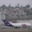

In [17]:
print(dataset_train[0])
print(dataset_train[0]['label'], labels.names[dataset_train[0]['label']])
dataset_train[0]["img"]

## 2.1 - Feature extractor

Preceding the ViT model, we use a *feature extractor*, which normalizes and resizes image `pixel_values` tensors. We initialize it from the HuggingFace `transformers` library like so:

In [18]:
from transformers import ViTFeatureExtractor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

As can be seen from the configuration, normalization and resizing are set to True by default. Normalization is performed across the three color channels using the mean and standard deviation values stored in `image_mean` and `image_std` respectively. The output size is set by `size` at $224 \times 224$ pixels.

To process an image with the feature extractor, we do the following:

In [19]:
example = feature_extractor(
    dataset_train[0]['img'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [20]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

We can apply this to both the training and testing dataset.

In [21]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

Later we'll be fine-tuning our ViT model with these tensors. Although fine-tuning is not as computationally heavy as pretraining, it still takes time. Therefore we ideally should be running everything on GPU rather CPU:

In [22]:
# load in relevant libraries, and alias where appropriate
import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 2.2 - Loading ViT

The next step is downloading and initializing ViT. Again, we are using HuggingFace `transformers` with the same `from_pretrained` methods used to load the feature extractor.

Because we are fine-tuning ViT for classification, we use the ViTForImageClassification class. By default, this will initialize a classification head with just two outputs. Since we have 10 classes in CIFAR-10, we must specify that via the `num_labels` parameter.

In [23]:
from transformers import ViTForImageClassification

labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
)

# move to GPU (if available)
model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

## 2.3 - Fine-tuning

We will implement fine-tuning using HuggingFace's `Trainer` function. `Trainer` is an abstract training and evaluation loop implemented in PyTorch for Transformer models.

There are several variables that we must define beforehand. First, we start with the collate function, which helps us handle the collation of our dataset into batches of tensors that will be fed into the model during training.

In [24]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Another important variable is the evaluation metric, which measures our model performance over time. In this case, we will use *accuracy*.

In [25]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

The final variable required by `Trainer` is the `TrainingArguments` configuration. These are:
* training parameters
* save settings
* logging settings

In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./models/cifar-10",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

With all this, we're ready to initialize Trainer and begin the training loop. 

Training will take some time, even on GPU (around 3 hours on a K80). Once complete, the best version of the model will be saved in the `output_dir` we set in the `TrainingArguments` config object.

In [27]:
from transformers import Trainer

# Training takes around 3 hours
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)
# begin training
results = trainer.train()

Bad pipe message: %s [b'\x8b\xc7\xa0\xf1\xc0\x06\xea\x96z\xdaZ\xaf\x10\xb3\xbb\xd5\x83N \x8b\x02T]bIZ\xb9\x8c\xdc\xb1\x04:@\x03\xcb\x9b\xf0I\x0fk,,`\x89\r\xbc{D\x9fY\x9d\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00']
Bad pipe message: %s [b'\x7f,\xb6\x83w\xa7S"\xfc\xdf\xc2\xb0\xbd\xf8cdA\xcf \xe4\xbe\xf6\xf7v\x9c/\xf0\xecq\xa7Uf\x1e\x02\x95\xeb:^\x1a\xa5\xe3f\xf1\xe3\xc4q\xb5\xcc\xeaU5\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17']
Bad pipe message: %s [b"#\xfeU\x99\xfe{x0l\x0e\xe9S\xf7\xa6%\x8b\x8e\x9f\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\

Step,Training Loss,Validation Loss


Attempted to log scalar metric loss:
2.147
Attempted to log scalar metric learning_rate:
0.00019968
Attempted to log scalar metric epoch:
0.0
Attempted to log scalar metric loss:
1.7473
Attempted to log scalar metric learning_rate:
0.00019936000000000002
Attempted to log scalar metric epoch:
0.01
Attempted to log scalar metric loss:
1.252
Attempted to log scalar metric learning_rate:
0.00019904
Attempted to log scalar metric epoch:
0.01
Attempted to log scalar metric loss:
0.8878
Attempted to log scalar metric learning_rate:
0.00019872000000000002
Attempted to log scalar metric epoch:
0.01
Attempted to log scalar metric loss:
0.7388
Attempted to log scalar metric learning_rate:
0.0001984
Attempted to log scalar metric epoch:
0.02


KeyboardInterrupt: 

## 2.4 - Evaluation and prediction

In [ ]:
# show the first image of the testing dataset
image = dataset_test["img"][0].resize((200,200))
image

In [ ]:
# extract the actual label for this image
actual_label = dataset_test["label"][0]

labels = dataset_test.features['label']
actual_label, labels.names[actual_label]

The image isn’t very clear, and most people would struggle to correctly classify the image. However, we can see from the label that this is a cat. Let’s see what the model predicts.

In this case, we can either use our own model or a fine-tuned model from the HuggingFace Hub

In [ ]:
from transformers import ViTForImageClassification

# import fine-tuned version of model from Hugging Face hub (if needed)
model_id = 'LaCarnevali/vit-cifar10'
model = ViTForImageClassification.from_pretrained(model_id)

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['label']
labels.names[predicted_label]